# 1. Import Libraries

In [10]:
import numpy as np
import random

import matplotlib.pyplot as plt 

# 2. Define Game Board for Connect4

In [11]:
class Board():
    def __init__(self, xmax, ymax):
        self.xmax = xmax
        self.ymax = ymax
        self.grid = np.zeros((self.ymax, self.xmax))
        self.player1 = 1.0 #use integer values to represent players
        self.player2 = 2.0
        self.draw = 99
        self.winner = None
    
    #clear the board
    def reset(self):
        self.grid = np.zeros((self.ymax, self.xmax))
        self.player1 = 1.0
        self.player2 = 2.0
        self.draw = 99
        self.winner = None
    
    #check if the column is full for inserting the coin
    def check_coin(self, column):
        if self.grid[0][column] != 0:
            return False #column is full
        else:
            return True

    #player insert the coin in chosen column
    def insert_coin(self, player, column):
        for i in range(self.ymax):
            if (self.grid[i][column] != 0):
                i -= 1
                break
        self.grid[i][column] = player
        
        #check if there is any winner
        if self.check_victory(column, i, player):
            self.winner = player
        #if the board is full, this is a draw
        for i in self.grid:
            if 0 in i:
                break
            else:
                if i == (len(self.grid)-1):
                    self.winner = self.draw
        return self.grid

    #go through all the lines to find scores
    def line_recursive(self, x, y, player, dx, dy, score):
        if (y + dy > (self.ymax-1)) or (y + dy < 0):
            return score
        if (x + dx > (self.xmax-1)) or (x + dx < 0):
            return score
        if self.grid[y + dy][x + dx] == player:
            return self.line_recursive(x + dx, y + dy, player, dx, dy, score + 1)
        else:
            return score

    #check if anyone wins and determine the winner
    def check_victory(self, x, y,player):
        #horizontal
        left = self.line_recursive(x, y, player, -1, 0, 0)
        right = self.line_recursive(x, y, player, 1, 0, 0)
        if left + right > 2:
            #print("Player " + str(int(player)) + " wins!")
            return True
        
        #vertical
        up = self.line_recursive(x, y, player, 0, -1, 0)
        down = self.line_recursive(x, y, player, 0, 1, 0)
        if up + down > 2:
            #print("Player " + str(int(player)) + " wins!")
            return True
        
        #diag1
        upleft = self.line_recursive(x, y, player, -1, -1, 0)
        downright = self.line_recursive(x, y, player, 1, 1, 0)
        if upleft + downright > 2:
            #print("Player" + str(int(player)) + "wins!")
            return True
        
        #diag2
        upright = self.line_recursive(x, y, player, 1, -1, 0)
        downleft = self.line_recursive(x, y, player, -1, 1, 0)
        if upright + downleft > 2:
            #print("Player" + str(int(player)) + "wins!")
            return True
    
    #get the current state of the game
    def get_state(self):
        arr = []
        for i in self.grid:
            arr.append(tuple(i))
        return tuple(arr)
    

In [12]:
test_board = Board(7, 6)

test_board.insert_coin(test_board.player1, 3)
test_board.insert_coin(test_board.player1, 3)
test_board.insert_coin(test_board.player1, 3)
test_board.insert_coin(test_board.player1, 3)

print(test_board.grid)

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


# 3. Define Agents
## 3.1. Baseline Random Agent

In [13]:
class RandomAgent(object):
    def __init__(self, board):
        self.board = board
        self.player = 1

    def take_turn(self):
        #take a random action
        action = np.random.randint(0, self.board.xmax - 1)
        self.board.insert_coin(1, action)

## 3.2 TD Agent (super class for Q-learning and SARSA agents)

In [14]:
class TDAgent(): 
    def __init__(self, board, epsilon, alpha, gamma, player):
        self.board = board
        self.Q = {} #Q will be a dict of k:v pairs of [board state]: [dictionary of k:v pairs of [the action]:[its q-value]]
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.player = player
        self.history = [] #a record of time steps required to win
        self.win = 0

        self.Q_INITIAL = {}
        for i in range(self.board.xmax):
            self.Q_INITIAL[i] = 1
        #this is the q-table entry never-before-seen states are initialized to, as creating an initial q-table with initial values
        #would be extremely time and space consuming.
    

    def select_action(self, state):
        #choose action with epsilon greedy policy
        r = np.random.random()
        
        if r < self.epsilon:
            action = np.random.randint(0, self.board.xmax -1)
        else:
            current = self.Q[state] #retrieve q-table entry
            actions = current.keys() #retrieve Q-values for the current q-table entry

            max = -float('inf') #find the action corresponding to the maximum Q-value for the selected q-table entry
            action = None
            for i in actions:
                if current[i] > max:
                    max = current[i]
                    action = i
       
        return action


    def get_reward(self):
        reward = 0
        
        if self.board.winner: #if a winner has been declared...
            if self.board.winner == self.player: #if the q-learning agent won...
                reward = 1 #set a positive reward
            elif self.board.winner != self.board.draw:
                reward = -2 #otherwise, the q-learning agent lost, so set a negative reward
            else:
                reward = -1 #in case of a draw, but try not to
        return reward
    

    def updateQ(self, old_state, action):
        pass #update function is defined differently for each agent


    def take_turn(self):
        old_state = self.board.get_state() #retrieves and stores current state
        if old_state not in self.Q.keys():
            self.Q[old_state] = self.Q_INITIAL
        action = self.select_action(old_state) #stores chosen action
        if self.board.check_coin == False: #column is full, cannot insert to a full column
            action = self.select_action(old_state) #action invalid, choose another action
        self.board.insert_coin(self.player, action) #executes action
        new_state = self.board.get_state()
        if new_state not in self.Q.keys(): #if the action executed results in reaching an unindexed state...
            self.Q[new_state] = self.Q_INITIAL #initialize that state in the Q-table.
        self.updateQ(old_state, action) #updates Q-value for old state and chosen action


    def train(self, episodes):
        rnd = RandomAgent(self.board)
        for epi in range(0,episodes):
            time = 0
            self.board.reset()
            while not self.board.winner:
                rnd.take_turn()
                self.take_turn()
                time += 1
            if self.board.winner == self.player:
                self.win += (1/episodes)
            self.history.append(time)

        #plot the time steps taken for the agent to win in each episode    
        plt.plot(self.history[:100])
        plt.xlabel('Episodes')
        plt.ylabel('Time steps')
        plt.show(True)
        plt.close()

        print("Average steps it took for winning is: ", np.average(self.history))
        print("Percentage of our agent winning is: ", self.win)
            

## 3.3 SARSA Agent

In [15]:
class SarsaAgent(TDAgent):
    def __init__(self, board, epsilon, alpha, gamma, player):
        super().__init__(board, epsilon, alpha, gamma, player)
    
    def updateQ(self, old_state, action):
        new_state = self.board.get_state()
        next_action = self.select_action(new_state)
        next_Q = self.Q[new_state][next_action]
        
        # Q = Q + alpha(reward + gamma * Q for executed new action - Q)
        self.Q[old_state][action] += self.alpha * ((self.get_reward() + self.gamma * next_Q) - self.Q[old_state][action])

## 3.4 Q-Learning Agent

In [16]:
class QLearningAgent(TDAgent):
    def __init__(self, board, epsilon, alpha, gamma, player):
        super().__init__(board, epsilon, alpha, gamma, player)
    
    def updateQ(self, old_state, action):
        current_q_entry = self.Q[self.board.get_state()]

        maxq = -float('inf')
        for i in current_q_entry.keys():
            if current_q_entry[i] > maxq:
                maxq = current_q_entry[i] #gets the maximum Q value amongst the current q-table entry's actions
        
        # Q = Q + alpha(reward + gamma * maxQ' - Q)
        self.Q[old_state][action] += self.alpha * ((self.get_reward() + self.gamma * maxq) - self.Q[old_state][action])

## 3.5 Double Q-Learning Agent

In [17]:
class DoubleQLAgent(TDAgent):
    def __init__(self, board, epsilon, alpha, gamma, player):
        super().__init__(board, epsilon, alpha, gamma, player)
        self.Q2 = {} #second q table for double q-learning


    def select_action(self, state):
        #choose action with epsilon greedy policy
        r = np.random.random()
        
        if r < self.epsilon:
            action = np.random.randint(0, self.board.xmax -1)
        else:
            current1 = self.Q[state] #retrieve q-table entry
            actions1 = current1.keys() #retrieve Q-values for the current q-table entry

            current2 = self.Q2[state]
            actions2 = current2.keys()

            max1 = -float('inf') #find the action corresponding to the maximum Q-value for the selected q-table entry
            action1 = None
            for i in actions1:
                if current1[i] > max1:
                    max1 = current1[i]
                    action1 = i

            max2 = -float('inf') #find the action corresponding to the maximum Q-value for the selected q-table entry
            action2 = None
            for i in actions2:
                if current2[i] > max2:
                    max2 = current2[i]
                    action2 = i
            
            #choose the action with a higher q-value
            if max1 < max2:
                action = action2
            else:
                action = action1
       
        return action


    def updateQ(self, old_state, action):
        current_q1_entry = self.Q[self.board.get_state()]
        current_q2_entry = self.Q2[self.board.get_state()]

        maxq1 = -float('inf')
        for i in current_q1_entry.keys():
            if current_q1_entry[i] > maxq1:
                maxq1 = current_q1_entry[i] #gets the maximum Q value amongst the current q-table1 entry's actions
        
        maxq2 = -float('inf')
        for i in current_q2_entry.keys():
            if current_q2_entry[i] > maxq2:
                maxq2 = current_q2_entry[i] #gets the maximum Q value amongst the current q-table2 entry's actions
        
        maxq = max(maxq1, maxq2) #update with the higher maximum Q value
        # Q = Q + alpha(reward + gamma * maxQ' - Q)
        self.Q[old_state][action] += self.alpha * ((self.get_reward() + self.gamma * maxq) - self.Q[old_state][action])
    

    def take_turn(self):
        old_state = self.board.get_state() #retrieves and stores current state
        if old_state not in self.Q.keys():
            self.Q[old_state] = self.Q_INITIAL
            self.Q2[old_state] = self.Q_INITIAL
        action = self.select_action(old_state) #stores chosen action
        if self.board.check_coin == False: #column is full, cannot insert to a full column
            action = self.select_action(old_state) #action invalid, choose another action
        self.board.insert_coin(self.player, action) #executes action
        new_state = self.board.get_state()
        if new_state not in self.Q.keys(): #if the action executed results in reaching an unindexed state...
            self.Q[new_state] = self.Q_INITIAL #initialize that state in both Q-tables.
            self.Q2[new_state] = self.Q_INITIAL
        self.updateQ(old_state, action) #updates Q-value for old state and chosen action


# 4 Train the agents and report the results

SARSA Agent:


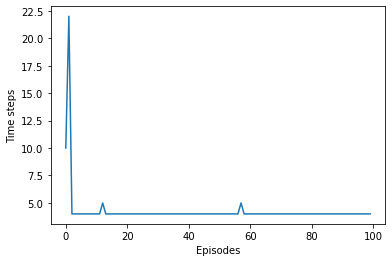

Average steps it took for winning is:  4.0435
Percentage of our agent winning is:  0.9979999999999455

Q-Learning Agent:


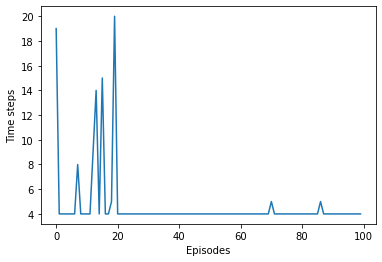

Average steps it took for winning is:  4.0705
Percentage of our agent winning is:  0.9954999999999458

Double Q-Learning Agent:


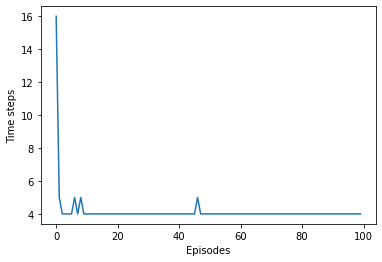

Average steps it took for winning is:  4.0425
Percentage of our agent winning is:  0.9984999999999454


In [18]:
c4_board = Board(7,6)
print("SARSA Agent:")
q2 = SarsaAgent(c4_board, 0.01, 0.1, 0.9, 2)
q2.train(2000)
print("\nQ-Learning Agent:")
ql = QLearningAgent(c4_board, 0.01, 0.1, 0.9, 2)
ql.train(2000)
print("\nDouble Q-Learning Agent:")
dql= DoubleQLAgent(c4_board, 0.01, 0.1, 0.9, 2)
dql.train(2000)